# Load libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from natsort import natsorted
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Load h5ad data

See what is in the cell metadata (obs) slot and the gene information (var) slots: `adata.obs` and `adata.var`

Sample dataset in B6J mouse brain.

In [2]:
adata = sc.read("/data/class/cosmos_cluster6/PUBLIC/ref/example_pbmc_adata.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 10000 × 56953
    obs: 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc', 'sublibrary', 'Sample', 'Experiment', 'Genotype', 'Notes', 'Tissue', 'Tissue_ID', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Tissue_weight_mg', 'n_counts', 'doublet_scores'
    var: 'gene_id', 'gene_name'
    layers: 'raw_counts'

In [4]:
adata.obs.head()

,bc1_sequence,bc2_sequence,bc3_sequence,bc,sublibrary,Sample,Experiment,Genotype,Notes,Tissue,...,DOB,Age_weeks,Age_days,Body_weight_g,Estrus_cycle,Dissection_date,Dissection_time,Tissue_weight_mg,n_counts,doublet_scores
kallisto_cellID,,,,,,,,,,,,,,,,,,,,,
A6_B10_D7.13H,CCAATTCT,ACGTATCA,CTCAATGA,CTCAATGAACGTATCACCAATTCT,13H,117_B6J_10M_21,igvf_b01,B6J,NaN,LeftCortex,...,11/8/2022,10,72,13.2,Diestrus,1/19/2023,10:57 AM,119,1477.0,0.192308
B5_C5_D10.13D,CCGTTCTA,ATTGAGGA,GAATCTGA,GAATCTGAATTGAGGACCGTTCTA,13D,106_CASTJ_10F_21,igvf_b01,CASTJ,NaN,LeftCortex,...,11/22/2022,10,72,24.0,NaN,2/2/2023,10:35 AM,147,6696.0,0.104072
C3_B4_E3.13F,ACACCTTT,AAGACGGA,GCGAGTAA,GCGAGTAAAAGACGGAACACCTTT,13F,120_B6J_10F_21,igvf_b01,B6J,NaN,LeftCortex,...,11/8/2022,10,72,14.9,NaN,1/19/2023,12:34 PM,133,758.0,0.021322
C2_G1_H12.13G,TCATTGCA,AATGTTGC,GCCAAGAC,GCCAAGACAATGTTGCTCATTGCA,13G,119_B6J_10M_21,igvf_b01,B6J,NaN,LeftCortex,...,11/8/2022,10,72,13.8,Metestrus,1/19/2023,11:05 AM,106,1561.0,0.171779
A6_F5_B5.13C,CCAATTCT,TGGAACAA,AAGGTACA,AAGGTACATGGAACAACCAATTCT,13C,117_B6J_10M_21,igvf_b01,B6J,NaN,LeftCortex,...,11/8/2022,10,72,13.2,Diestrus,1/19/2023,10:57 AM,119,7044.0,0.110112


In [5]:
adata.var.head()

,gene_id,gene_name
gene_name,,
4933401J01Rik,ENSMUSG00000102693.2,4933401J01Rik
Gm26206,ENSMUSG00000064842.3,Gm26206
Xkr4,ENSMUSG00000051951.6,Xkr4
Gm18956,ENSMUSG00000102851.2,Gm18956
Gm37180,ENSMUSG00000103377.2,Gm37180


# Calculate QC metrics

In [6]:
adata.var['mt'] = adata.var['gene_name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Plot QC metrics

In [7]:
def plot_knee(adata, category_column='sublibrary'):
    unique_categories = natsorted(adata.obs[category_column].unique())
    color_palette = sns.color_palette("husl", n_colors=len(unique_categories))

    fig, ax = plt.subplots(figsize=(10, 7))

    for category, color in zip(unique_categories, color_palette):
        # subset the data for each sublibrary
        subset = adata[adata.obs[category_column] == category]

        # calculate knee and num_cells for the subset
        knee = np.sort((np.array(subset.layers['raw_counts'].sum(axis=1))).flatten())[::-1]
        cell_set = np.arange(len(knee))
        num_cells = cell_set[::-1][0]

        # plot the knee for the current sublibrary
        ax.loglog(cell_set, knee, linewidth=2, color=color, label=f"{category}")

    ax.axhline(y=500, linewidth=3, color="k", linestyle='--')

    ax.set_ylabel("UMI Counts",fontsize=18)
    ax.set_xlabel("Set of Barcodes",fontsize=18)
    ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.grid(True, which="both")

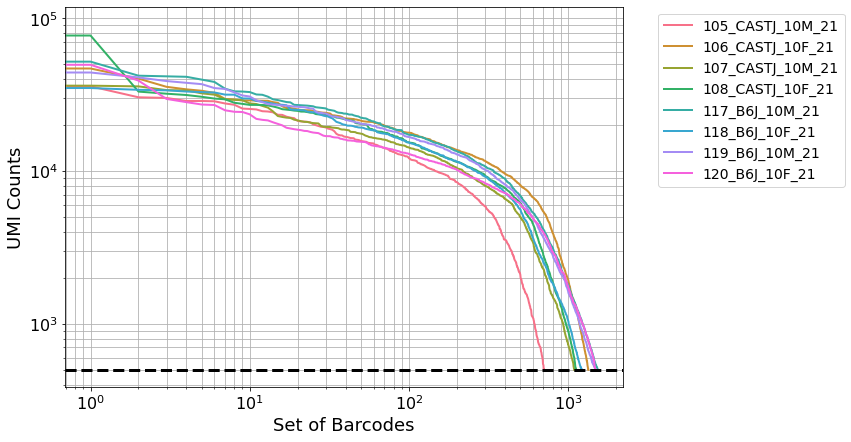

In [8]:
plot_knee(adata, category_column='Sample')

plt.show()

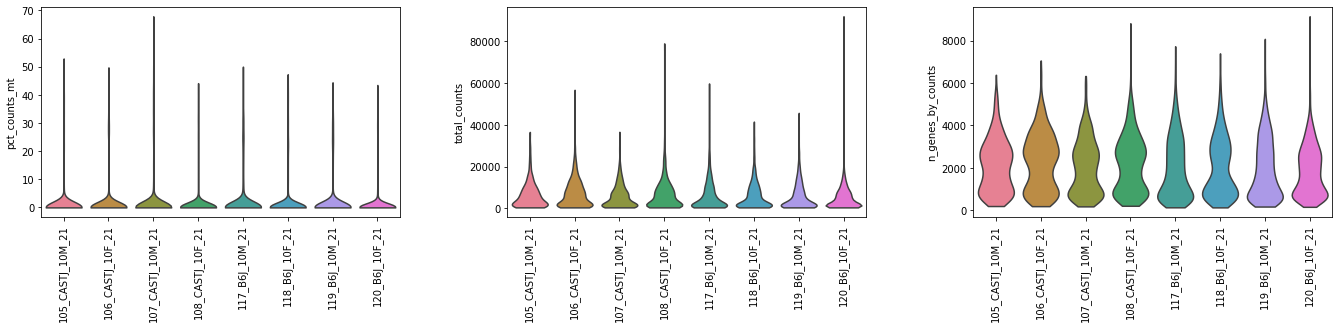

In [9]:
color_palette = sns.color_palette("husl", n_colors=len(adata.obs['Sample'].unique()))

sc.pl.violin(adata, ['pct_counts_mt', 'total_counts', 'n_genes_by_counts'],
             groupby = "Sample", palette = color_palette,
             jitter=0.4, multi_panel=True, size=0, rotation = 90)


# QC filter cells

In [10]:
sc.pp.filter_cells(adata, min_counts = 500) # UMI cutoff
sc.pp.filter_cells(adata, min_genes = 250) # min number of genes per cell


In [11]:
# filtering cells by mt content 
adata = adata[adata.obs.pct_counts_mt < 1, :].copy()

# filter cells by doublet score (scrublet)
adata = adata[adata.obs.doublet_scores < 0.25, :].copy()


In [12]:
adata

AnnData object with n_obs × n_vars = 8202 × 56953
    obs: 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc', 'sublibrary', 'Sample', 'Experiment', 'Genotype', 'Notes', 'Tissue', 'Tissue_ID', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Tissue_weight_mg', 'n_counts', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw_counts'

# Normalize the data

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4) # Counts per 10k
sc.pp.log1p(adata)


# Calculate highly variable genes

In [14]:
# highly variable genes are used to compute the clustering 
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

adata_hv = adata[:, adata.var.highly_variable].copy()


In [15]:
# notice the dimensions changed! subset to the top 2,000 most variable genes for further processing
adata_hv 

AnnData object with n_obs × n_vars = 8202 × 2000
    obs: 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc', 'sublibrary', 'Sample', 'Experiment', 'Genotype', 'Notes', 'Tissue', 'Tissue_ID', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Tissue_weight_mg', 'n_counts', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_counts'

# Regress technical variables
Percent mitochondrial expression and number of genes expressed per nucleus

In [16]:
sc.pp.regress_out(adata_hv, ['pct_counts_mt','n_genes_by_counts'])
sc.pp.scale(adata_hv, max_value=10)


# PCA

In [17]:
sc.tl.pca(adata_hv)

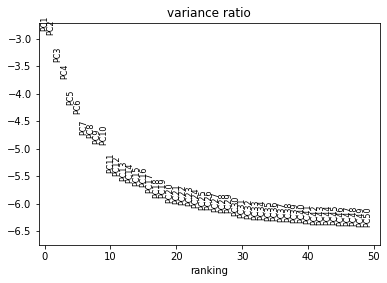

In [18]:
sc.pl.pca_variance_ratio(adata_hv, log=True, n_pcs=50) # scanpy generates the filename automatically


# KNN and leiden clustering

In [19]:
sc.pp.neighbors(adata_hv, n_pcs=30) # choose PC where variance ratio starts to level out -- typically around 30

sc.tl.leiden(adata_hv, resolution = 1)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarni

# UMAP: Uniform Manifold Approximation and Projection

In [20]:
sc.tl.umap(adata_hv)


# Transfer processed info back to original adata

So that we have all the genes in the scanpy object, not just highly variable (for downstream plotting/analysis purposes)

In [21]:
adata.uns['neighbors'] = adata_hv.uns['neighbors']
adata.uns['leiden'] = adata_hv.uns['leiden']
adata.uns['umap'] = adata_hv.uns['umap']
adata.obs['leiden'] = adata_hv.obs['leiden']
adata.obsm = adata_hv.obsm
adata.obsp = adata_hv.obsp


# Plot low-dimensionality representation

In [22]:
plt.rcParams['figure.figsize'] = (10, 8)

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


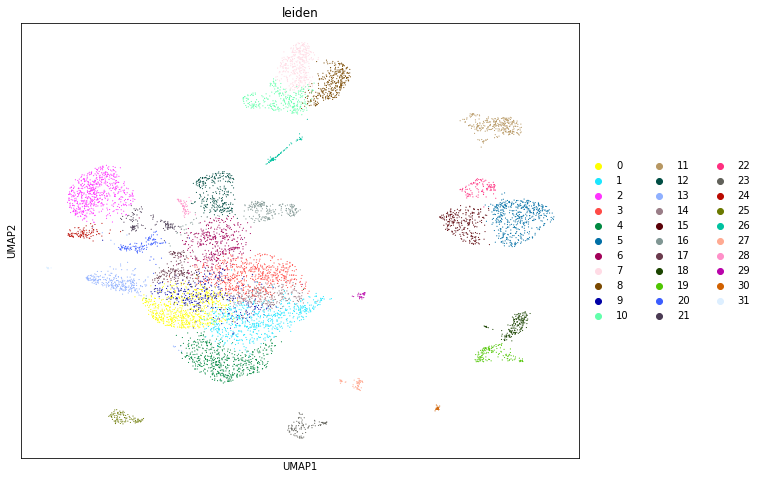

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


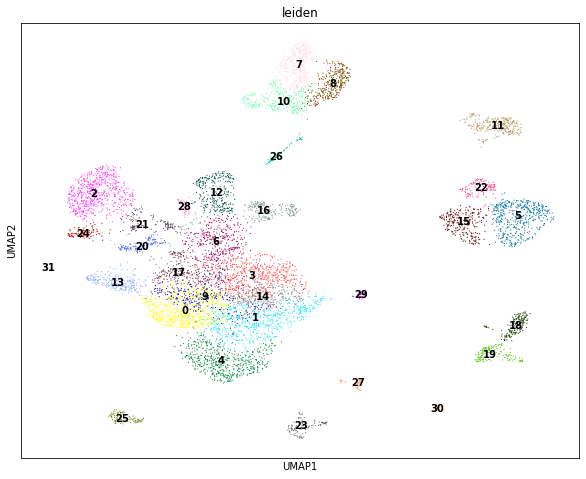

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


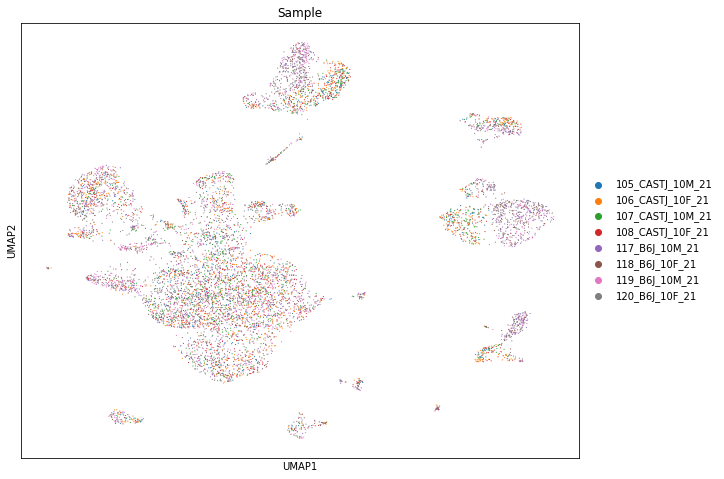

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


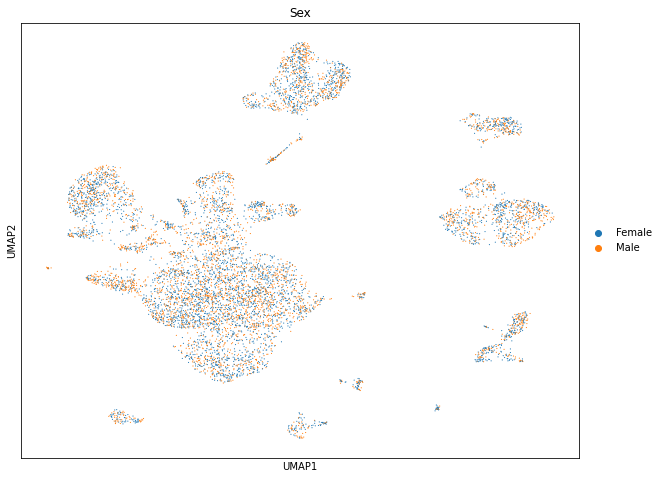

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


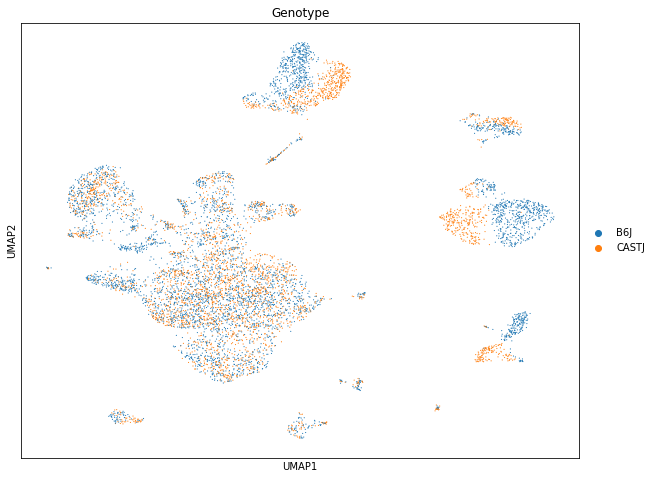

In [23]:
sc.pl.umap(adata, color=['leiden'], size = 5)
sc.pl.umap(adata, color=['leiden'], size = 5, legend_loc = "on data")
sc.pl.umap(adata, color=['Sample'], size = 5)
sc.pl.umap(adata, color=['Sex'], size = 5)
sc.pl.umap(adata, color=['Genotype'], size = 5)


# Cluster proportions bar plots 
Much more informative -- Ali prefers this kind of plot over a UMAP ;)

In [24]:
def stacked_barplot_proportions(adata, cluster_key, var_key, fsize=(12, 6), annotations=True, reverse_order=False, custom_order=None, custom_colors=None):
    colors = sns.color_palette("husl", n_colors=len(adata[var_key].unique()))

    # Group the data by 'cluster_key' and 'var_key', count occurrences, and calculate proportions
    grouped_data = adata.groupby([cluster_key, var_key]).size().unstack().fillna(0)
    proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0)

    # Apply custom order if provided
    if custom_order:
        proportions = proportions.loc[custom_order]
    if custom_colors:
        colors = custom_colors

    # Reverse the order of the DataFrame if reverse_order is True
    if reverse_order:
        proportions = proportions.iloc[::-1]
        m = adata.groupby([cluster_key]).size().to_frame().iloc[::-1]
    else:
        m = adata.groupby([cluster_key]).size().to_frame()

    #sns.set_style('white')
    # Create the stacked bar plot
    ax = proportions.plot(kind='barh', color=colors, stacked=True, figsize=fsize, width=0.8, edgecolor=None)

    if annotations:
        for i, txt in enumerate(m[0]):
            ax.text(0.875, i, txt, fontsize=14, va='center', transform=ax.get_yaxis_transform())

    plt.xlim(0, 1.15)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_xlabel("Proportion")
    ax.set_ylabel(cluster_key)
    ax.set_title(f'{var_key} by {cluster_key}')

    if annotations:
        ax.legend(title=var_key, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.get_legend().remove()

    ax.grid(False)
    plt.show()

In [ ]:
stacked_barplot_proportions(adata.obs, cluster_key = 'leiden', fsize = (5,8),
                            var_key = 'Sample', reverse_order = True)


In [ ]:
stacked_barplot_proportions(adata.obs, cluster_key = 'leiden', fsize = (5,8),
                            var_key = 'Sex', reverse_order = True)


In [ ]:
stacked_barplot_proportions(adata.obs, cluster_key = 'leiden', fsize = (5,8),
                            var_key = 'Genotype', reverse_order = True)


# Check marker gene expression

In [ ]:
markers_df = pd.read_csv("/data/class/cosmos_cluster6/PUBLIC/ref/IGVF_curated_markers.csv")
markers_df = markers_df[markers_df['Gene'].isin(adata.var_names)]
markers_df = markers_df[markers_df['Tissue'] == 'CortexHippocampus']
markers_df['gene_name'] = markers_df['Gene']
markers_df = markers_df.drop_duplicates(subset=['Subtype', 'gene_name'])

markers_dict = markers_df.groupby('Subtype')['gene_name'].apply(list).to_dict()


In [ ]:
sc.pl.dotplot(adata, markers_dict, 'leiden', 
              mean_only_expressed = False,
              dendrogram=True, log=True)



In [ ]:
smol_marker_genes_dict = {
    "Endothelial": ["Flt1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC": ["Dcn"],
    "Epithelial":["Kl","Ttr","Clic6"],
    "Ependymal":["Tmem212","Dnah6"],
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Gfap","Clu"],
    "Neuron": ["Slc17a7","Gad1","Gad2"],
    "CR": ["Reln"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mbp","Plp1"],
    "MOL": ["Plp1","Mag","Mog",]
}

In [ ]:
sc.pl.dotplot(adata, smol_marker_genes_dict, 'leiden', 
              mean_only_expressed = False,
              dendrogram=True, log=True)



# Assign each cluster a celltype

In a new "obs" column called "celltype"

In [ ]:
adata.obs["celltype"] = adata.obs["leiden"].map(
    {
        "0": "Neuron",
        "1": "Neuron",
        "2": "Neuron",
        "3": "Neuron",
        "4": "Neuron",
        "5": "Oligodendrocyte",
        "6": "Neuron",
        "7": "Astrocyte",
        "8": "Astrocyte",
        "9": "Neuron",
        "10": "Astrocyte",
        "11": "OPC",
        "12": "Neuron",
        "13": "Neuron",
        "14": "Neuron",
        "15": "Oligodendrocyte",
        "16": "Neuron",
        "17": "Neuron",
        "18": "Microglia",
        "19": "Microglia",
        "20": "Neuron",
        "21": "Neuron",
        "22": "Oligodendrocyte",
        "23": "Pericyte",
        "24": "Neuron",
        "25": "Endothelial",
        "26": "Neuron",
        "27": "Mural",
        "28": "Neuron",
        "29": "Fibroblast",
        "30": "Ependymal",
        "31": "Epithelial"
    }
)


In [ ]:
sc.pl.umap(adata, color=['celltype'], size = 5)


# Save processed adata

In [ ]:
#adata.write_h5ad('/data/class/cosmos_cluster6/PUBLIC/ref/example_pbmc_adata_processed.h5ad')
